In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [51]:
from sklearn.datasets import load_breast_cancer
from torchvision import datasets, transforms

In [4]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['class'] = cancer['target']
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [14]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]

In [15]:
ratios = [0.6, 0.2, 0.2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

In [16]:
indices = torch.randperm(data.size(0))
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
# X를 리스트로 바꿔줘야만 아래 박스 코드가 작동 → 왜지? 아, 튜플은 immutable이기 때문에
X = list(X.split(cnts, dim=0))
y = y.split(cnts, dim=0)

In [17]:
scaler = StandardScaler()
scaler.fit(X[0].numpy())
X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

In [19]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=30, out_features=25, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=25, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=15, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
  (11): Sigmoid()
)


In [20]:
optimizer = optim.Adam(model.parameters())

In [21]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

In [22]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [23]:
train_history, valid_history = ([], [])

for i in range(n_epochs):
    indices = torch.randperm(X[0].size(0))
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = (0, 0)
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            valid_loss += float(loss)
            y_hat = [y_hat_i]
        
    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.4e}, valid loss={valid_loss:.4e}, lowest loss={lowest_loss:.4e}')
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4e}')

model.load_state_dict(best_model)

Epoch 10: train loss=1.2532e-01, valid loss=2.0694e-01, lowest loss=2.3193e-01
Epoch 20: train loss=4.1756e-02, valid loss=2.0572e-01, lowest loss=1.7720e-01
Epoch 30: train loss=2.4397e-02, valid loss=2.2625e-01, lowest loss=1.7720e-01
Epoch 40: train loss=1.1223e-02, valid loss=2.6151e-01, lowest loss=1.7720e-01
Epoch 50: train loss=2.5209e-03, valid loss=3.1829e-01, lowest loss=1.7720e-01
Epoch 60: train loss=8.5343e-04, valid loss=3.9592e-01, lowest loss=1.7720e-01
Epoch 70: train loss=3.7830e-04, valid loss=4.4886e-01, lowest loss=1.7720e-01
Epoch 80: train loss=2.3061e-04, valid loss=4.8746e-01, lowest loss=1.7720e-01
Epoch 90: train loss=1.4879e-04, valid loss=5.1487e-01, lowest loss=1.7720e-01
Epoch 100: train loss=1.1095e-04, valid loss=1.1907e+00, lowest loss=1.7720e-01
Epoch 110: train loss=7.9757e-05, valid loss=1.2081e+00, lowest loss=1.7720e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 13: 1.7720e-01


<All keys matched successfully>

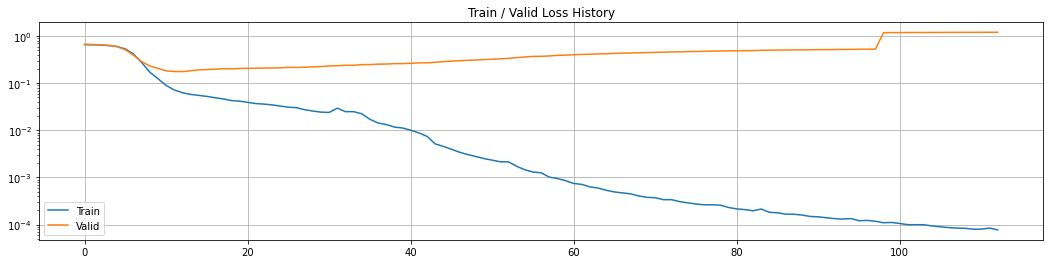

In [25]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [26]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4e}')
print(f'Valid loss: {sorted_history[0][1]:.4e}')
print(f'Test loss: {test_loss:.4e}')

Train loss: 6.3062e-02
Valid loss: 1.7720e-01
Test loss: 2.6576e-02


In [34]:
correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = float(y[2].size(0))

print(f'Test Accuracy: {correct_cnt / total_cnt:.4f}')

Test Accuracy: 1.0000


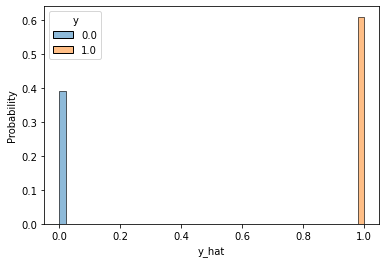

In [49]:
df = pd.DataFrame(torch.concat([(y_hat > 0.5).float(), y[2]], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [47]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

1.0

In [52]:
train = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [53]:
def plot(X):
    img = np.array(X.detach().cpu(), dtype='float').reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

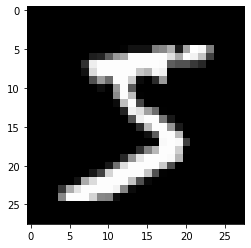

In [54]:
plot(train.data[0])

In [64]:
X = train.data.float() / 255
y = train.targets
X = X.reshape(X.size(0), -1)
X.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [66]:
input_size = X.size(-1)
output_size = int(max(y)) + 1

In [74]:
ratios = [0.8, 0.2]
train_cnt = int(X.size(0) * ratios[0])
valid_cnt = X.size(0) - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

In [75]:
indices = torch.randperm(X.size(0))
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

In [76]:
X += [(test.data.float() / 255).reshape(test_cnt, -1)]
y += [test.targets]

In [77]:
for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [78]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)


In [79]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [80]:
n_epochs = 1000
batch_size = 256
print_interval = 100
early_stop = 100

In [81]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [83]:
train_history, valid_history = ([], [])

for i in range(n_epochs):
    indices = torch.randperm(X[0].size(0))
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = (0, 0)
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)

    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.4e}, valid loss={valid_loss:.4e}, lowest loss={lowest_loss:.4e}')
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4e}')

model.load_state_dict(best_model)


Epoch 100: train loss=6.0704e-08, valid loss=1.9532e-01, lowest loss=9.3667e-02
There is no improvement during last 100 epochs.
The best validation loss from epoch 6: 9.3667e-02


<All keys matched successfully>

In [85]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())
        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4e}')
print(f'Valid loss: {sorted_history[0][1]:.4e}')
print(f'Test loss: {test_loss:.4e}')

Train loss: 4.6878e-02
Valid loss: 9.3667e-02
Test loss: 7.9639e-02


In [86]:
correct_cnt = (y[2].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[2].size(0))
print(f'Test Accuracy: {correct_cnt / total_cnt:.4f}')

Test Accuracy: 0.9775


In [88]:
pd.DataFrame(confusion_matrix(y[2], torch.argmax(y_hat, dim=-1)), index=[f'True_{i}' for i in range(10)], columns=[f'Pred_{i}' for i in range(10)])

,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8,Pred_9
True_0,965,0,1,1,0,2,9,1,1,0
True_1,0,1130,0,0,0,0,1,1,3,0
True_2,2,1,1012,4,1,0,0,10,2,0
True_3,0,0,5,987,0,3,0,7,7,1
True_4,2,2,4,0,955,1,6,5,1,6
True_5,3,0,0,10,1,865,3,1,6,3
True_6,1,4,0,0,1,10,936,0,6,0
True_7,1,0,7,3,1,0,0,1011,1,4
True_8,3,1,4,5,4,4,0,5,945,3
True_9,4,5,0,8,14,1,0,6,2,969
